# 6 : Try to explain GNN
See : https://pytorch-geometric.readthedocs.io/en/latest/tutorial/explain.html 

https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer.py 

In [1]:
import pandas as pd
import numpy as np

from utils.preProcessing import preProcessing

from sklearn.preprocessing import StandardScaler

## 0. Reading and preprocessing

In [2]:
# Reading
df = pd.read_excel('data/table-s1-sigmut-indel.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = preProcessing.delete_nan_values(df)

# Relabel patients
t = 183
df = preProcessing.relabel_patients(df, "Progression_1","Time to progression (days)",t)

# Select features
features_name = ["CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]
features_to_normalize = ["CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df.loc[:,features_to_normalize] = StandardScaler().fit_transform(df.loc[:,features_to_normalize].to_numpy())

# Extract features
X = df.loc[:,features_name].to_numpy()

# Numerize label
y = df["Progression_1"].to_numpy()

## 1. Explain Logistic Regression

In [3]:
from models.LogisticRegression import LogisticRegression 
from manage.LogisticRegressionTrainTestManager import LogisticRegressionTrainTestManager

log_reg_clf = LogisticRegression(len(features_name))
log_reg_manager = LogisticRegressionTrainTestManager(log_reg_clf)

In [4]:
# Make the leave one out cross validation
n_epochs = 50
scores_log_reg, classes_log_reg, train_loss_log_reg, val_loss_log_reg, std_train_loss_log_reg, std_val_loss_log_reg, params_fc_log_reg = log_reg_manager.leave_one_out_cross_validation(X, y, n_epochs)

In [5]:
import shap
import torch

X_torch = torch.from_numpy(X).float()

explainer = shap.DeepExplainer(log_reg_manager.model, X_torch)
shap_values = explainer.shap_values(X_torch)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


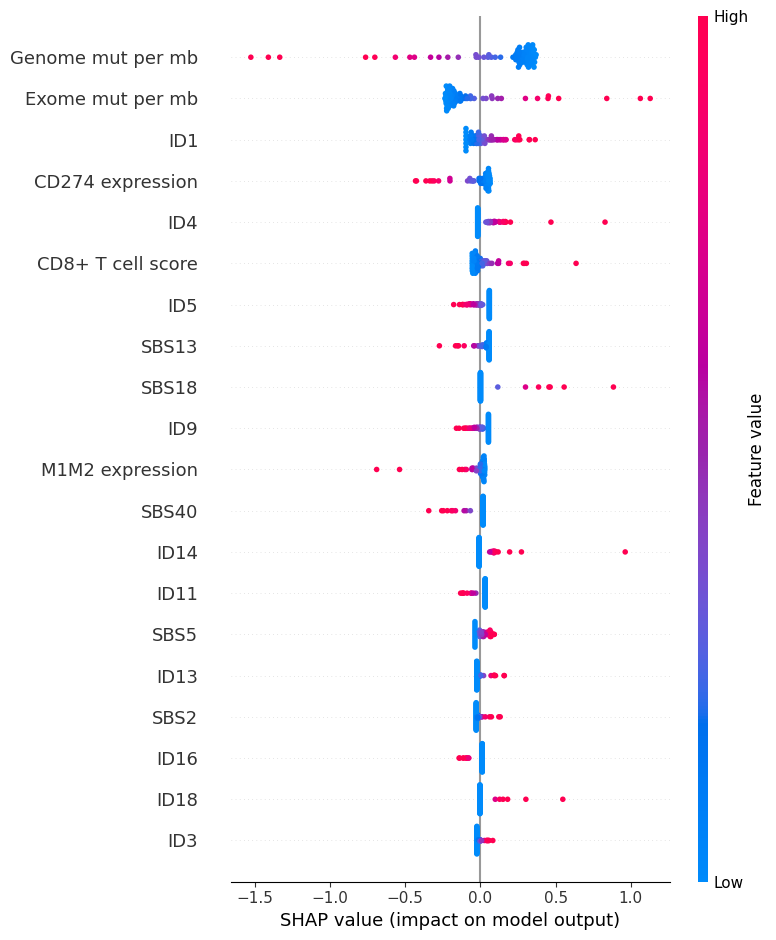

In [6]:
shap.summary_plot(shap_values, X_torch, feature_names=features_name)

## 2. Explain GCN

In [7]:
from models.BuildGraph import BuildGraph
from sklearn.metrics import euclidean_distances

group = df["Tumour type"].to_numpy()
distance_matrix = euclidean_distances(X)
max_neighbors = 3

build_graph = BuildGraph(X, y, group)
build_graph.build_graph(distance_matrix, max_neighbors, True)

pyg_graph = build_graph.pyg_graph

In [8]:
from models.GCNClassifier import GCNClassifier
from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager

gcn_clf = GCNClassifier(len(features_name))
gcn_manager = GCNClassifierTrainTestManager(gcn_clf)

In [9]:
# Make the leave one out cross validation
n_epochs = 5
scores_gcn, classes_gcn, train_loss_gcn, val_loss_gcn, std_train_loss_gcn, std_val_loss_gcn, params_conv_gcn, params_fc_gcn = gcn_manager.leave_one_out_cross_validation(X, y, group, n_epochs, "euclidean",3)

In [10]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=gcn_manager.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

# Generate explanation for the node at index `10`:
explanation = explainer(pyg_graph.x, pyg_graph.edge_index)

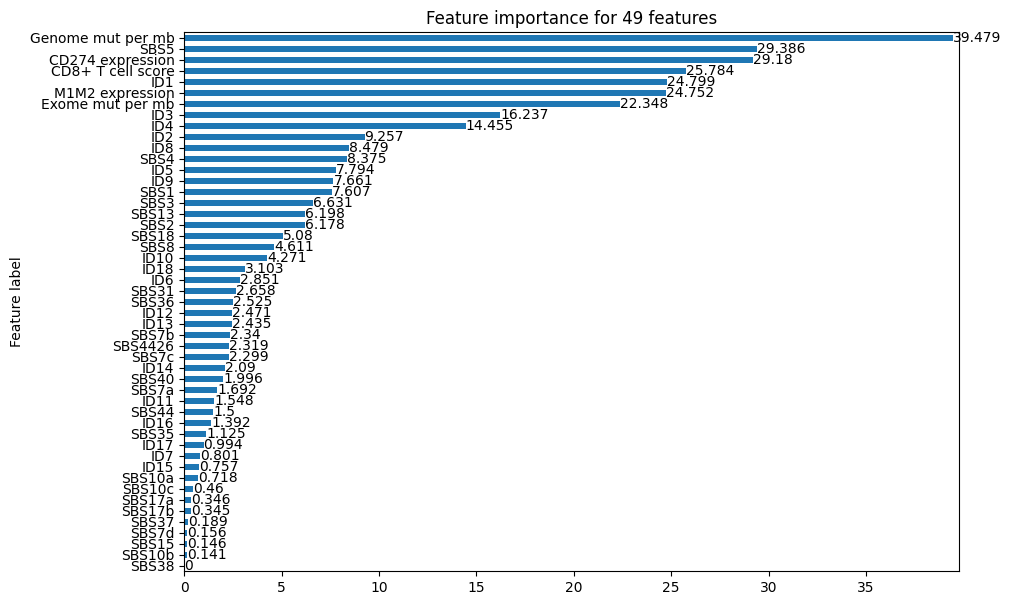

In [11]:
# Somme de l'impact de chaque caractéristique, pour chaque patient
explanation.visualize_feature_importance(feat_labels=features_name)

## Explain GAT

In [12]:
from models.BuildGraph import BuildGraph

group = df["Tumour type"].to_numpy()

build_graph = BuildGraph(X, y, group)
build_graph.build_graph(None, None, False)

pyg_graph = build_graph.pyg_graph

In [13]:
from models.GATClassifier import GATClassifier
from manage.GATClassifierTrainTestManager import GATClassifierTrainTestManager

gat_clf = GATClassifier(len(features_name))
gat_manager = GATClassifierTrainTestManager(gat_clf)

In [15]:
# Make the leave one out cross validation
n_epochs = 5
scores_gat, classes_gat, train_loss_gat, val_loss_gat, std_train_loss_gat, std_val_loss_gat, params_attention_gat, params_conv_gat, params_fc_gat = gat_manager.leave_one_out_cross_validation(X, y, group, n_epochs)

In [16]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=gat_manager.model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)

# Generate explanation for the node at index `10`:
explanation = explainer(pyg_graph.x, pyg_graph.edge_index)

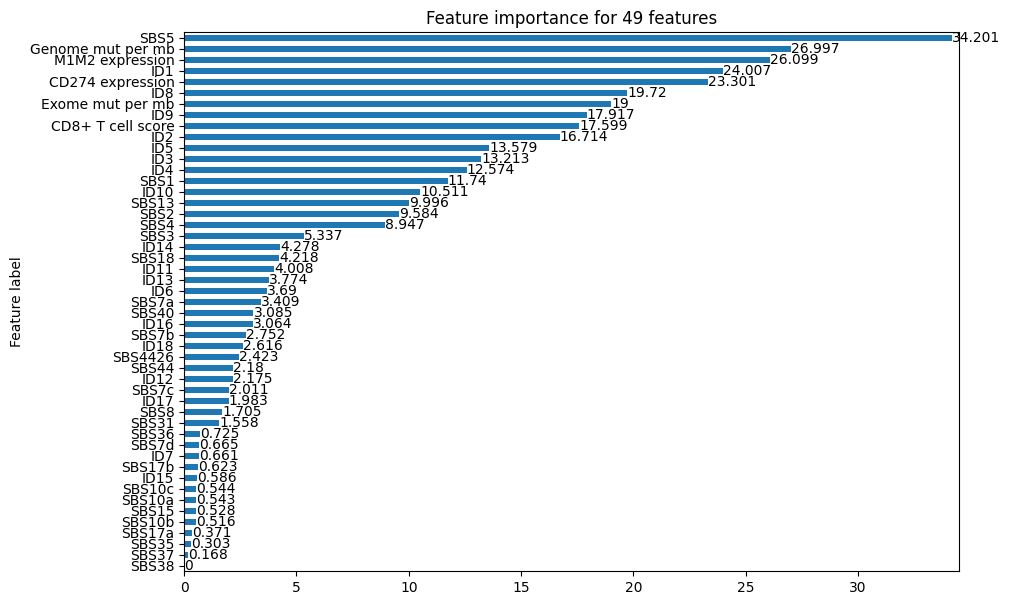

In [17]:
# Somme de l'impact des caractéristiques de tous les patients
explanation.visualize_feature_importance(feat_labels=features_name)